# 01 Import libraries

In [1]:
import nasdaqdatalink
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.\

# 02 Import Data

In [2]:
path = r'/Users/woodoooo/Desktop/World University Rankings/02_Data/Original Data'

In [3]:
df = pd.read_csv(os.path.join(path, 'SEENRTERTFMZSECA.csv'))

Why I chose this dataset:
I selected the “Ratio of Female to Male Tertiary School Enrollment for Developing Countries in Europe and Central Asia” dataset because it provides a clear gender-based metric of access to higher education. Since university rankings often consider factors such as diversity, inclusivity, and gender equality, this dataset allows me to explore how gender balance in tertiary education may relate to the academic environment and overall reputation of universities in this region. Using this data, I can potentially connect trends in gender parity to broader patterns affecting university performance or social impact.

https://fred.stlouisfed.org/series/SEENRTERTFMZSECA


In [4]:
df.head()

,observation_date,SEENRTERTFMZSECA
0,1970-01-01,1.13827
1,1971-01-01,1.12289
2,1972-01-01,1.12632
3,1973-01-01,1.12707
4,1974-01-01,1.12861


In [5]:
df.shape

(53, 2)

In [6]:
type(df)

pandas.core.frame.DataFrame

In [7]:
df.columns = ['Date', 'Value']

In [8]:
from datetime import datetime

In [9]:
df['datetime'] = pd.to_datetime(df['Date'])

In [10]:
data = df.set_index('datetime') # Set the datetime as the index of the dataframe.

In [11]:
data.head()

,Date,Value
datetime,,
1970-01-01,1970-01-01,1.13827
1971-01-01,1971-01-01,1.12289
1972-01-01,1972-01-01,1.12632
1973-01-01,1973-01-01,1.12707
1974-01-01,1974-01-01,1.12861


In [12]:
data.drop('Date', axis=1, inplace=True)

In [13]:
data.head()

,Value
datetime,
1970-01-01,1.13827
1971-01-01,1.12289
1972-01-01,1.12632
1973-01-01,1.12707
1974-01-01,1.12861


In [20]:
data.columns

Index(['Value'], dtype='object')

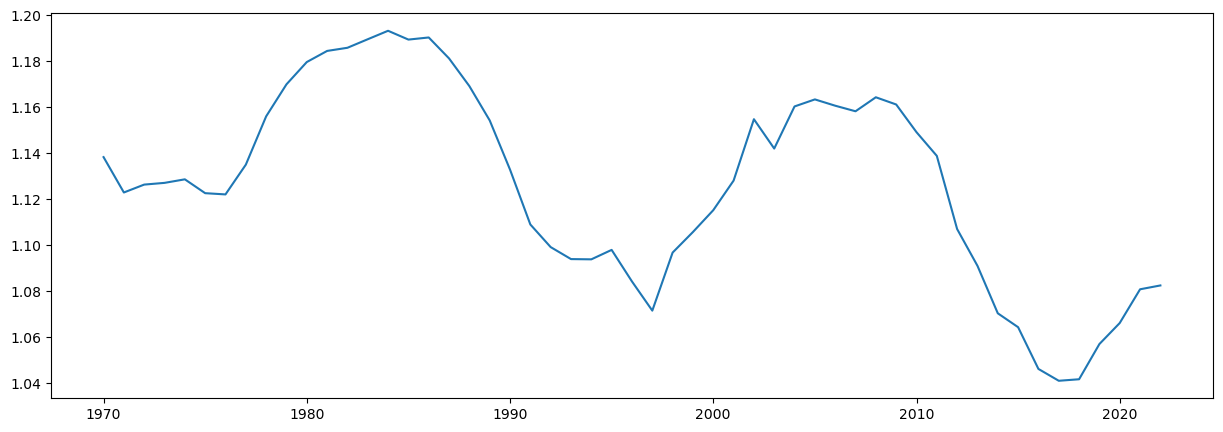

In [14]:
plt.figure(figsize= (15,5))
plt.plot(data)

In [25]:
print(data.index.dtype)

datetime64[ns]


In [33]:
data.describe()

,Value
count,53.000000
mean,1.126303
std,0.042999
min,1.041020
25%,1.093930
50%,1.128060
75%,1.160620
max,1.193200


In [26]:
print(pd.Series(data.index).describe())

count                               53
mean     1996-01-01 09:03:23.773584896
min                1970-01-01 00:00:00
25%                1983-01-01 00:00:00
50%                1996-01-01 00:00:00
75%                2009-01-01 00:00:00
max                2022-01-01 00:00:00
Name: datetime, dtype: object


In [27]:
data.isnull().sum()

Value    0
dtype: int64

In [29]:
data.duplicated().sum()

np.int64(0)

# 03 Time-series analysis: decomposition

In [30]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data, model='additive')

In [31]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

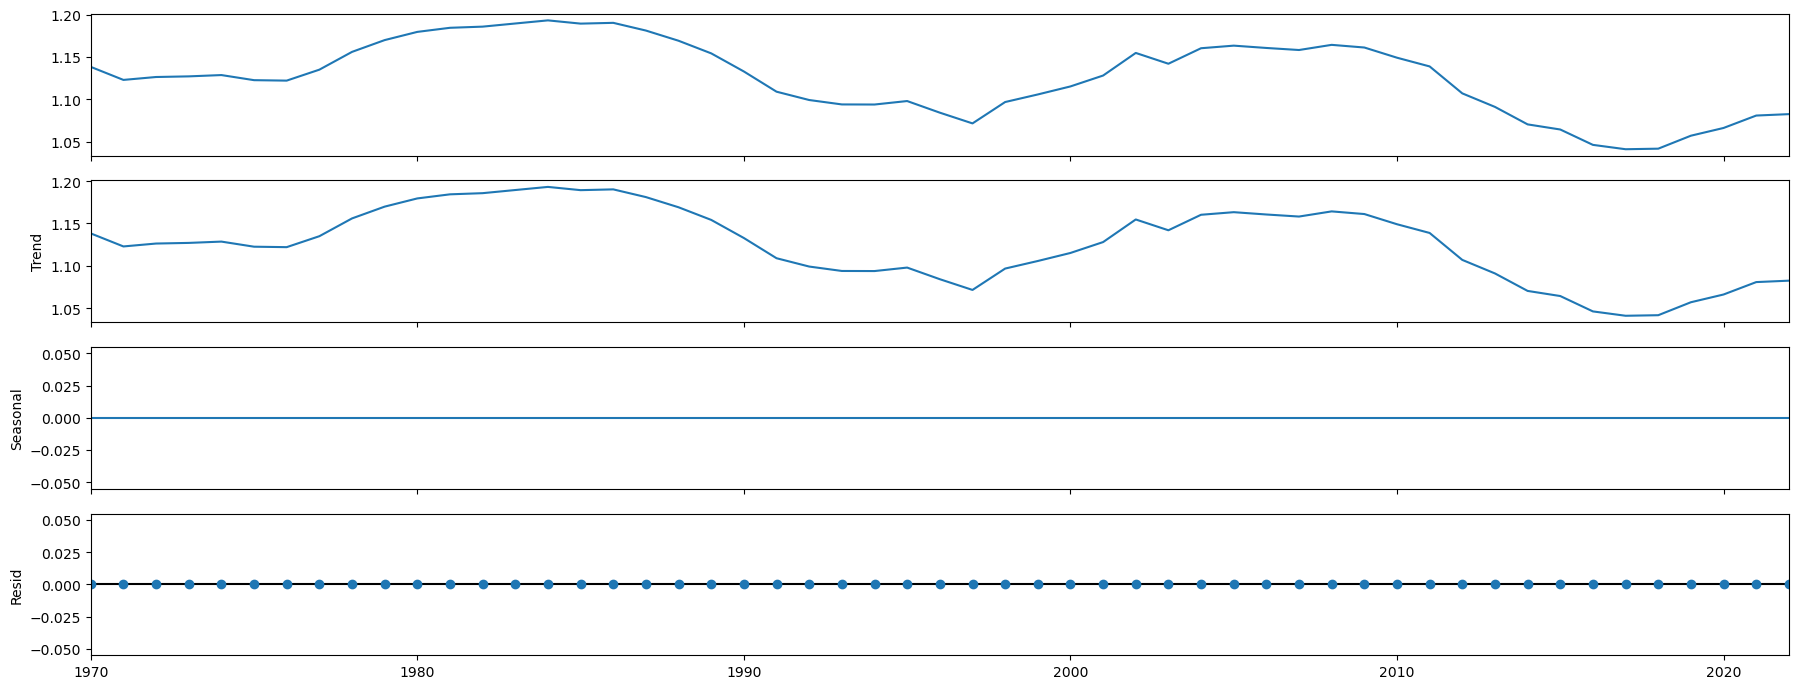

In [32]:
# Plot the separate components

decomposition.plot()
plt.show()

Trend: Clearly visible (long-term upward, then downward, then up again).

Seasonal: Flat line → no repeating seasonal pattern detected.

Resid (noise): Very small, almost zero → your data is smooth, with little irregular/random variation.



The data looks non-stationary because it has a clear trend (mean is not constant over time).
It also shows almost no noise (residuals are minimal). 
That makes sense: this is an aggregate ratio across countries, which smooths out random fluctuations.

In [38]:
# choose a modern historical period (e.g., post-1990 after the Soviet collapse, 
# since before that the numbers could reflect very different education systems).
data_sub = data.loc['1990-01-01': '2022-01-01']

In [37]:
data_sub.shape

(33, 1)

In [41]:
decomposition_2 = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [40]:
rcParams['figure.figsize'] = 18, 7

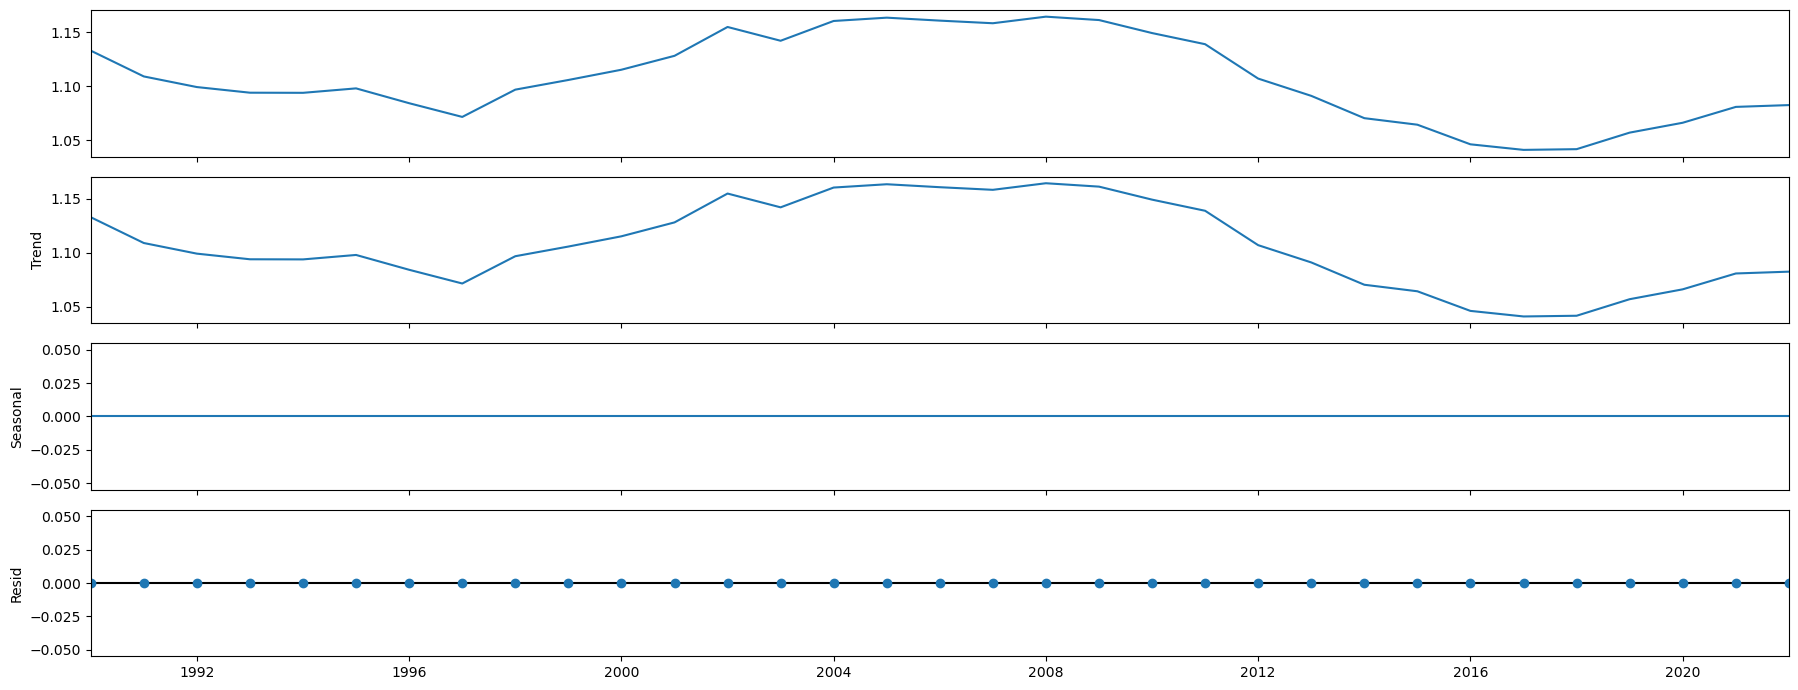

In [44]:
decomposition_2.plot()
plt.show()

# 04 Testing for stationarity

In [45]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.914251
p-value                         0.325387
Number of Lags Used             9.000000
Number of Observations Used    23.000000
Critical Value (1%)            -3.752928
Critical Value (5%)            -2.998500
Critical Value (10%)           -2.638967
dtype: float64


test Statistic is -1.914251 and p-value is higher (0.325387) > 0,05 -- dataset has unit root and it's not stationary

we can't reject H₀.

That means our data is non-stationary (matches what we saw in the decomposition: clear trend, no seasonality, minimal noise).

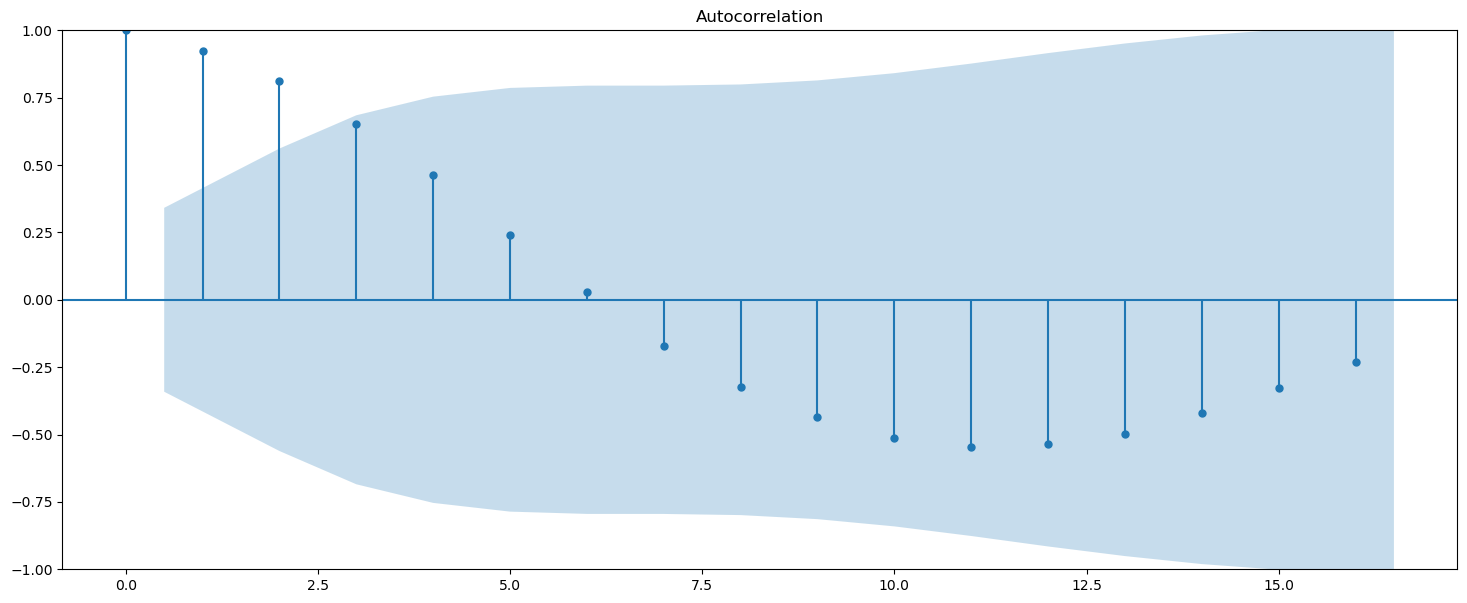

In [46]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

# 05 Stationarizing the Federal Reserve Economic Data

In [47]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [48]:
data_diff.dropna(inplace = True)

In [49]:
data_diff.head()

,Value
datetime,
1991-01-01,-0.02385
1992-01-01,-0.00983
1993-01-01,-0.00522
1994-01-01,-0.00011
1995-01-01,0.00411


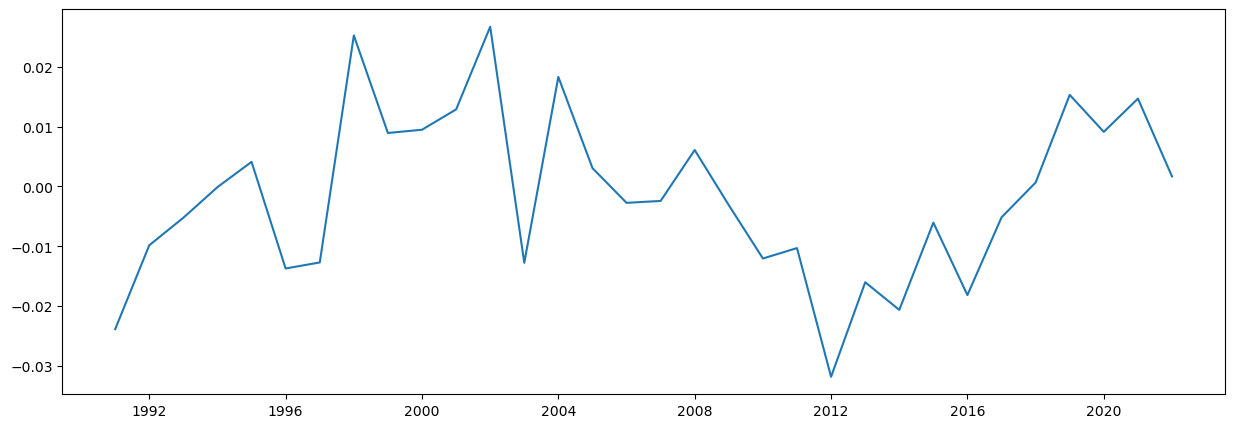

In [50]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [51]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -1.917984
p-value                         0.323649
Number of Lags Used             4.000000
Number of Observations Used    27.000000
Critical Value (1%)            -3.699608
Critical Value (5%)            -2.976430
Critical Value (10%)           -2.627601
dtype: float64


Test statistic = -1.92

p-value = 0.324 (> 0.05)

Critical values: still not below 10% threshold (needs to be smaller than -2.63).
Even after one round of differencing, the series is still non-stationary.

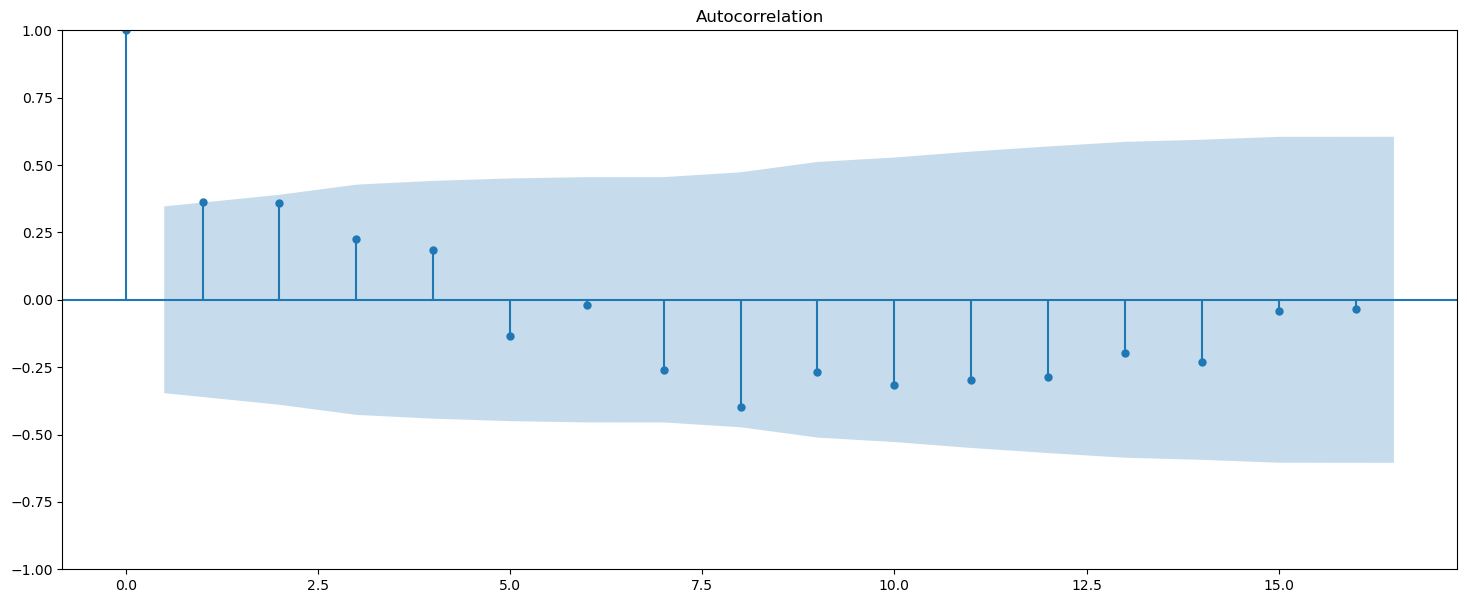

In [52]:
plot_acf(data_diff)
plt.show()

In [55]:
data_diff2 = data_sub.diff().diff().dropna()

In [57]:
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                -9.273286e+00
p-value                        1.309233e-15
Number of Lags Used            0.000000e+00
Number of Observations Used    3.000000e+01
Critical Value (1%)           -3.669920e+00
Critical Value (5%)           -2.964071e+00
Critical Value (10%)          -2.621171e+00
dtype: float64


ADF statistic = -9.27 (much smaller than the critical values at 1%, 5%, 10%).

p-value ≈ 0.0 (≪ 0.05).

We can reject the null hypothesis.
That means the differenced series is now stationary 

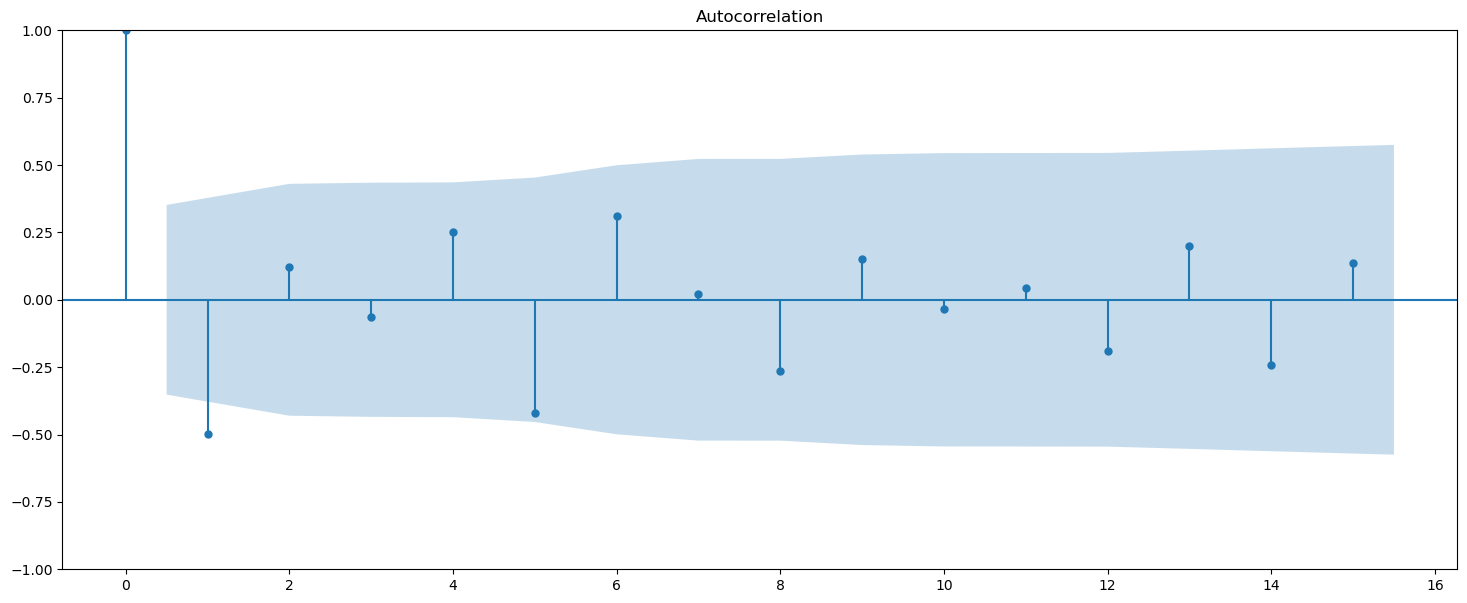

In [63]:
plot_acf(data_diff2['Value'])
plt.show()

The ratio of female to male enrollment shows a clear trend over time, but after differencing, the changes are stable and predictable.

This indicates that gender parity in tertiary education in these countries is evolving steadily, without unpredictable fluctuations or shocks.

From a university rankings perspective, it suggests that improvements in female enrollment relative to male enrollment are systematic rather than random, and can be meaningfully compared across years or countries.

# 06 Time Series Forecasting in Python Bonus

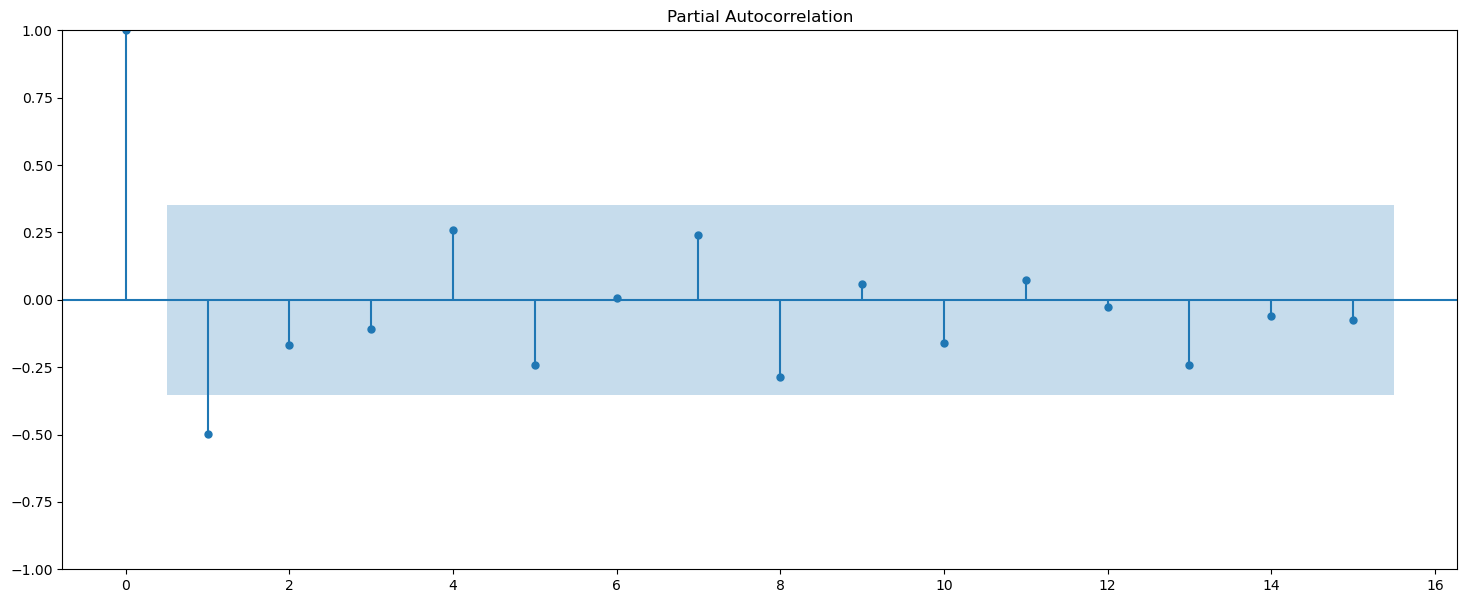

<Figure size 4500x4500 with 0 Axes>

In [65]:
# Plot partial autocorrelations to determine parameter p

plot_pacf(data_diff2)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

There's a very strong spike at lag 1 (around 1.0), which is highly significant

Interpretation for ARIMA parameter selection:
Based on this PACF plot, we have one reasonable option for the AR parameter (p):

p = 1: -- clearly significant spike at lag 1


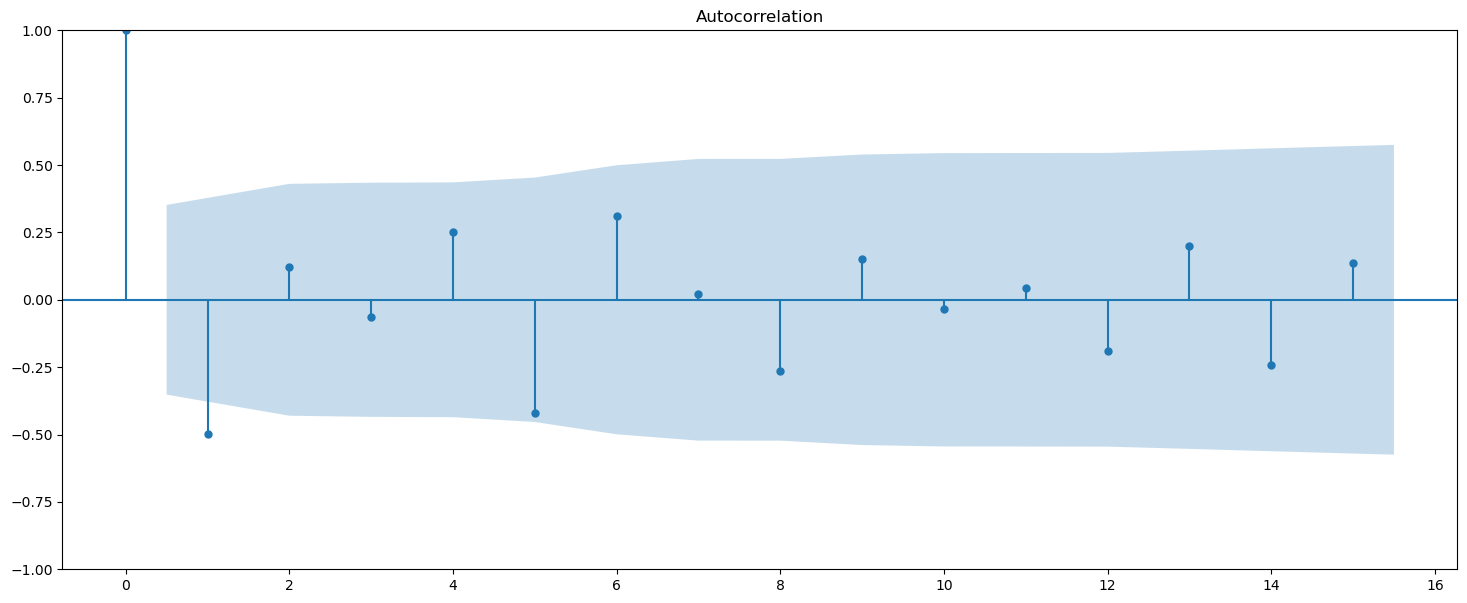

<Figure size 1500x500 with 0 Axes>

In [66]:
# Plot autocorrelations to determine parameter q

plot_acf(data_diff2)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

### 2. Splitting the Data

In [68]:
data_diff2.shape

(31, 1)

In [69]:
train = data_diff2['Value'][:25]  # First 25 observations (80%)
test = data_diff2['Value'][25:]   # Last 6 observations (20%)

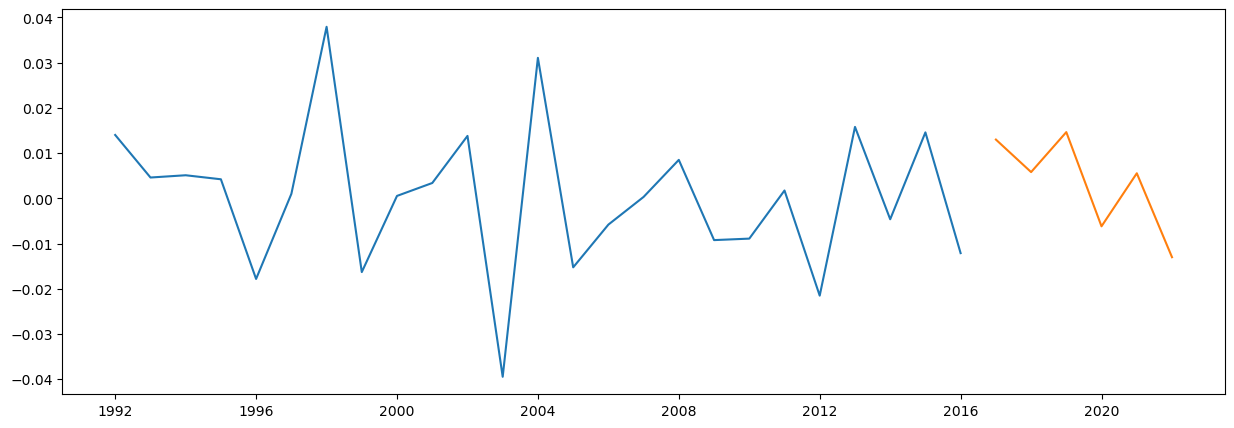

In [70]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [71]:
test.shape

(6,)

### 3. Running and Fitting the Model

In [72]:
from statsmodels.tsa.api import ARIMA # Import the model you need

In [76]:
# Use a simpler ARIMA model for small dataset
model = ARIMA(train, order=(1, 1, 2))  # Much simpler model
fitted = model.fit()
print(fitted.summary())

# Forecast - corrected syntax for newer statsmodels versions
forecast_steps = len(test)  # Should be 6, not 41
forecast_result = fitted.get_forecast(steps=forecast_steps)

# Extract forecast values and confidence intervals
fc = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Make into pandas series
fc_series = pd.Series(fc.values, index=test.index)
lower_series = pd.Series(conf_int.iloc[:, 0].values, index=test.index)
upper_series = pd.Series(conf_int.iloc[:, 1].values, index=test.index)

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   25
Model:                 ARIMA(1, 1, 2)   Log Likelihood                  67.754
Date:                Sun, 14 Sep 2025   AIC                           -127.507
Time:                        12:23:31   BIC                           -122.795
Sample:                    01-01-1992   HQIC                          -126.257
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0345      0.459      0.075      0.940      -0.866       0.935
ma.L1         -1.7521      1.515     -1.156      0.248      -4.722       1.218
ma.L2          0.9569      1.689      0.566      0.5

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


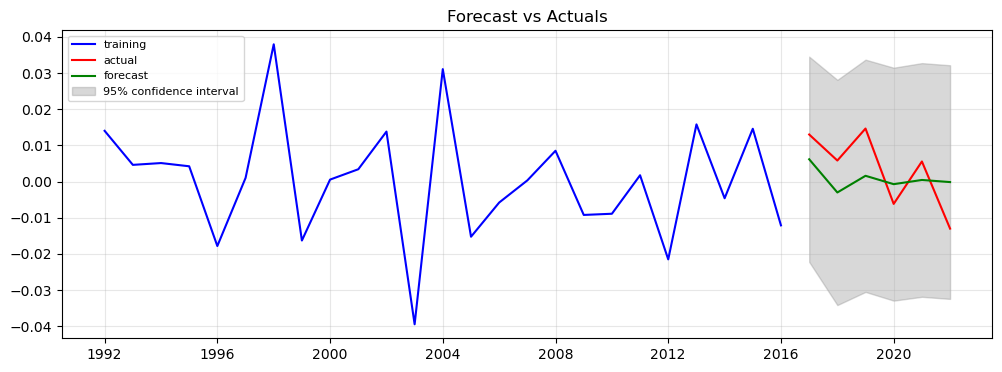


Forecast Accuracy Metrics:
MAE: 0.0087
RMSE: 0.0093
MAPE: 95.50%


In [75]:
# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training', color='blue')
plt.plot(test, label='actual', color='red')
plt.plot(fc_series, label='forecast', color='green')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='gray', alpha=0.3, label='95% confidence interval')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()

# Calculate forecast accuracy metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, fc_series)
rmse = np.sqrt(mean_squared_error(test, fc_series))
mape = np.mean(np.abs((test - fc_series) / test)) * 100

print(f"\nForecast Accuracy Metrics:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

### 4. Iterating

In [78]:
# Try simpler models with better statistical properties
import warnings
warnings.filterwarnings('ignore')

# Set frequency to avoid warnings
train.index.freq = 'YS'
test.index.freq = 'YS'

print("Comparing Different ARIMA Models:")
print("="*50)

# Models to test (keeping them simple for small dataset)
models_to_test = [
    (0, 1, 0),  # Random walk (just differencing)
    (1, 1, 0),  # AR(1) with differencing
    (0, 1, 1),  # MA(1) with differencing
    (1, 1, 1),  # ARIMA(1,1,1)
    (2, 1, 0),  # AR(2) with differencing
    (0, 1, 2),  # MA(2) with differencing
]

results = []

for order in models_to_test:
    try:
        model = ARIMA(train, order=order)
        fitted_model = model.fit()
        
        # Get forecasts
        forecast_result = fitted_model.get_forecast(steps=len(test))
        fc = forecast_result.predicted_mean
        
        # Calculate metrics
        from sklearn.metrics import mean_absolute_error, mean_squared_error
        import numpy as np
        
        mae = mean_absolute_error(test, fc)
        rmse = np.sqrt(mean_squared_error(test, fc))
        mape = np.mean(np.abs((test - fc) / test)) * 100
        
        # Check parameter significance (p-values < 0.05)
        p_values = fitted_model.pvalues[:-1]  # Exclude sigma2
        significant_params = sum(p_values < 0.05) if len(p_values) > 0 else 0
        total_params = len(p_values)
        
        results.append({
            'Order': order,
            'AIC': fitted_model.aic,
            'BIC': fitted_model.bic,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'Significant_Params': f"{significant_params}/{total_params}",
            'Model': fitted_model
        })
        
        print(f"ARIMA{order}:")
        print(f"  AIC: {fitted_model.aic:.2f}, BIC: {fitted_model.bic:.2f}")
        print(f"  MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.1f}%")
        print(f"  Significant parameters: {significant_params}/{total_params}")
        print()
        
    except Exception as e:
        print(f"ARIMA{order} failed: {str(e)}")
        print()

# Find best model based on multiple criteria
print("="*50)
print("MODEL SELECTION SUMMARY:")
print("="*50)

if results:
    # Sort by AIC (lower is better)
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('AIC')
    
    print("Top 3 models by AIC:")
    for i, row in results_df.head(3).iterrows():
        print(f"{i+1}. ARIMA{row['Order']} - AIC: {row['AIC']:.2f}, MAPE: {row['MAPE']:.1f}%, Sig.Params: {row['Significant_Params']}")
    
    # Recommend best model
    best_model = results_df.iloc[0]
    print(f"\n🎯 RECOMMENDED MODEL: ARIMA{best_model['Order']}")
    print(f"   Reasoning: Lowest AIC ({best_model['AIC']:.2f}) with reasonable performance")
    
    # Show detailed summary of best model
    print(f"\n📊 BEST MODEL DETAILED SUMMARY:")
    print(best_model['Model'].summary())

else:
    print("No models converged successfully. Try even simpler approaches.")

Comparing Different ARIMA Models:
ARIMA(0, 1, 0):
  AIC: -100.48, BIC: -99.31
  MAE: 0.0157, RMSE: 0.0183, MAPE: 184.2%
  Significant parameters: 0/0

ARIMA(1, 1, 0):
  AIC: -113.68, BIC: -111.33
  MAE: 0.0083, RMSE: 0.0091, MAPE: 94.2%
  Significant parameters: 1/1

ARIMA(0, 1, 1):
  AIC: -121.40, BIC: -119.05
  MAE: 0.0096, RMSE: 0.0104, MAPE: 99.2%
  Significant parameters: 0/1

ARIMA(1, 1, 1):
  AIC: -126.07, BIC: -122.53
  MAE: 0.0087, RMSE: 0.0093, MAPE: 95.5%
  Significant parameters: 1/2

ARIMA(2, 1, 0):
  AIC: -118.18, BIC: -114.64
  MAE: 0.0099, RMSE: 0.0107, MAPE: 107.2%
  Significant parameters: 1/2

ARIMA(0, 1, 2):
  AIC: -129.49, BIC: -125.95
  MAE: 0.0094, RMSE: 0.0110, MAPE: 91.8%
  Significant parameters: 0/2

MODEL SELECTION SUMMARY:
Top 3 models by AIC:
6. ARIMA(0, 1, 2) - AIC: -129.49, MAPE: 91.8%, Sig.Params: 0/2
4. ARIMA(1, 1, 1) - AIC: -126.07, MAPE: 95.5%, Sig.Params: 1/2
3. ARIMA(0, 1, 1) - AIC: -121.40, MAPE: 99.2%, Sig.Params: 0/1

🎯 RECOMMENDED MODEL: ARIMA(

In [79]:
# Use a simpler ARIMA model for small dataset
model = ARIMA(train, order=(0, 1, 2)) 
fitted = model.fit()
print(fitted.summary())

# Forecast - corrected syntax for newer statsmodels versions
forecast_steps = len(test)  # Should be 6, not 41
forecast_result = fitted.get_forecast(steps=forecast_steps)

# Extract forecast values and confidence intervals
fc = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Make into pandas series
fc_series = pd.Series(fc.values, index=test.index)
lower_series = pd.Series(conf_int.iloc[:, 0].values, index=test.index)
upper_series = pd.Series(conf_int.iloc[:, 1].values, index=test.index)

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   25
Model:                 ARIMA(0, 1, 2)   Log Likelihood                  67.743
Date:                Sun, 14 Sep 2025   AIC                           -129.486
Time:                        12:30:10   BIC                           -125.952
Sample:                    01-01-1992   HQIC                          -128.549
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.7569      1.726     -1.018      0.309      -5.139       1.625
ma.L2          0.9696      1.943      0.499      0.618      -2.839       4.778
sigma2         0.0002      0.000      0.533      0.5

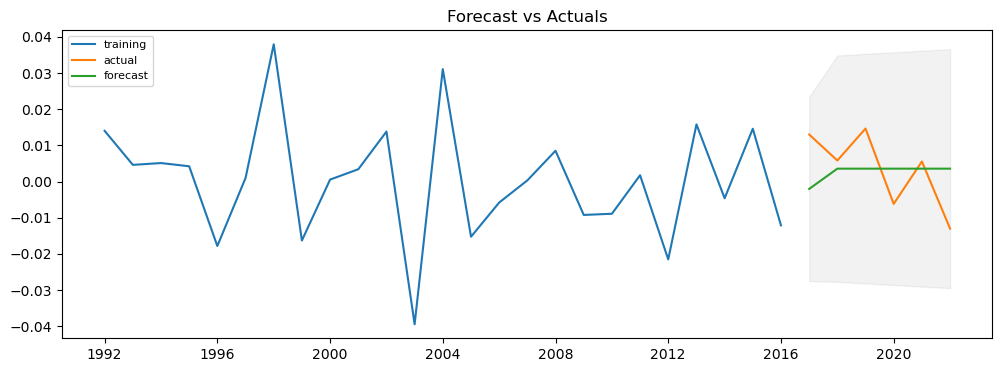

In [80]:
# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05) # This creates the confidence interval
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Why ARIMA Isn't Ideal Here:
1. Dataset Too Small: Only 31 observations is insufficient for reliable ARIMA parameter estimation. 
2. Poor Statistical Significance: Most ARIMA parameters have p-values > 0.05, meaning they're statistically meaningless - the model is essentially fitting noise.
3. Extremely High Forecast Errors: MAPE values of 90-180% indicate the model captures no meaningful predictive patterns.
4. Nature of the Data: Education enrollment ratios are influenced by policy changes, economic conditions, and social factors that ARIMA can't capture - it only uses historical values of the same variable.